# Crypto Price Prediction with Python

С помощью алгоритма машинного обучения будем прогнозировать будущую цену на криптовалюту, известную как **Dogecoin**.
![Dogecoin_img](img/Dogecoin_img.png)

1. [Importing Modules](#Importing-Modules)
1. [Explore the Data](#Explore-the-Data)
1. [Applying Machine Learning Model](#Applying-Machine-Learning-Model)
   1. [Visualize the target data](#Visualize-the-target-data)
   1. [Prepare data for ML model](#Prepare-data-for-ML-model)
   1. [Build LSTM model](Build-LSTM-model)
   1. [Model Fitting](#Model-Fitting)
   1. [Forecasting](#Forecasting)
1. [Usage ML model](#Usage-ML-model)

## Importing Modules

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

## Explore the Data

*Загрузка данных выполняется с помощью [**cryptocmd**](https://openbase.com/python/cryptocmd). Эта библиотека полезна для загрузки исторических данных о криптовалютах с сайта [Coinmarketcap](https://coinmarketcap.com/).*

Данные содержат:
* `Date`: дата записи
* `Open`: цена открытия *(цена, по которой актив, в данном случае Dogecoin, торгуется в начале дня)* (USD)
* `High`: максимальная цена дня *(самая высокая цена, достигнутая Dogecoin-ом в этот день)* (USD)
* `Low`: минимальная цена дня *(самая низкая цена, достигнутая Dogecoin-ом в этот день)* (USD)
* `Close`: цена закрытия *(цена, по которой Dogecoin торгуется в конце дня)* (USD)
* `Volume`: сумма фактических сделок, совершенных в течение дня, (USD)
* `Market Cap`: рыночная капитализация *(общая стоимость всех акций компании или, в случае Dogecoin или другой криптовалюты, всех монет, находящихся в обращении)* (USD)

In [4]:
# Data download
# ==============================================================================

# Scraper is initialized, symbol, start and end of download are included
scraper = CmcScraper('DOGE', '01-01-2021', '25-05-2022')

# Transform collected data into a dataframe
data = scraper.get_dataframe()

data

,Date,Open,High,Low,Close,Volume,Market Cap
0,2022-05-25,0.083628,0.084338,0.082319,0.082985,4.198348e+08,1.100970e+10
1,2022-05-24,0.083267,0.084317,0.080811,0.083637,4.624157e+08,1.109623e+10
2,2022-05-23,0.086084,0.088110,0.082858,0.083253,5.073852e+08,1.104524e+10
3,2022-05-22,0.084448,0.086480,0.084058,0.086105,3.750260e+08,1.142364e+10
4,2022-05-21,0.083972,0.085110,0.082932,0.084463,3.352460e+08,1.120574e+10
...,...,...,...,...,...,...,...
505,2021-01-05,0.009767,0.010219,0.008972,0.009920,6.872561e+08,1.268004e+09
506,2021-01-04,0.009784,0.011421,0.007878,0.009767,1.372399e+09,1.248287e+09
507,2021-01-03,0.010602,0.013867,0.009409,0.009771,2.707004e+09,1.248577e+09
508,2021-01-02,0.005686,0.013698,0.005584,0.010615,3.421563e+09,1.356281e+09


**Примечание**: Рынок криптовалют работает непрерывно 24/7. Однако не обязательно, чтобы *цена закрытия* совпадала с *ценой открытия* следующего дня. Это происходит из-за колебаний, которые может претерпеть стоимость Dogecoin-а или любой криптовалюты в течение последней секунды дня.

In [5]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
# data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
# data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
#                     axis=1)
data = data.loc[:, ['date', 'Close']]
data = data.rename({'Close': 'close'}, 
                     axis=1)
data = data.set_index('date')
data = data.sort_index(ascending=True)
data

,close
date,
2021-01-01,0.005685
2021-01-02,0.010615
2021-01-03,0.009771
2021-01-04,0.009767
2021-01-05,0.009920
...,...
2022-05-21,0.084463
2022-05-22,0.086105
2022-05-23,0.083253


## Applying Machine Learning Model

### Visualize the target data

Построим линейный график зависимости значения target-атрибута `close` от атрибута `date`.

In [6]:
def lines_plot(line_labels, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    for line, label in line_labels:
        ax.plot(line, label=label, linewidth=lw)
    ax.set_xlabel('date', fontsize=14)
    ax.set_ylabel('price of Close', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

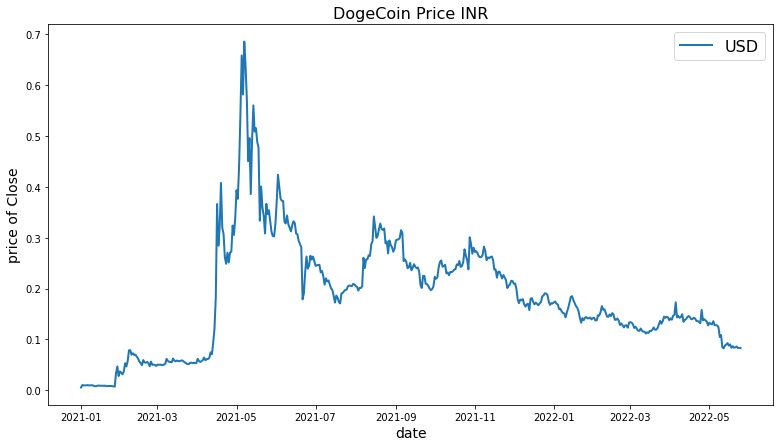

In [7]:
lines_plot([(data['close'], 'USD')], title='DogeCoin Price INR')

Можем наблюдать скачок цен в апреле 2021 года. Далее с июня 2021 года цена пошла на спад и продолжает опускаться по сей день.

### Prepare data for ML model

Разделим данные на два набора — обучающий набор и тестовый набор (80% на 20% соответственно).

In [8]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

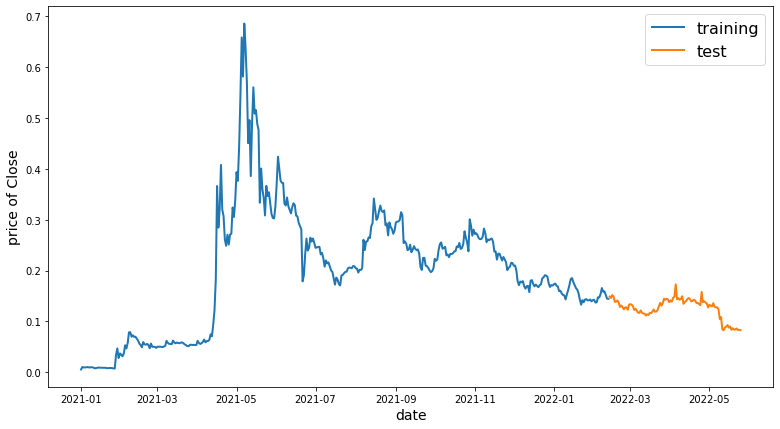

In [9]:
train, test = train_test_split(data, test_size=0.2)
lines_plot([
    (train['close'], 'training'),
    (test['close'], 'test')
], title='')

Далее была подготовлена функция нормализации данных. Цель нормализации — привести значения числовых столбцов в наборе данных к общему масштабу, не искажая разбросы в диапазонах значений.

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_Z(df):
    return (df - df.mean()) / df.std()

Функция для извлечения данных окнами заданного размера.

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

Итоговая функция подготовки данных:

In [12]:
def prepare_data_for_model(train_data, test_data, window_len=5, zero_base=True):
    # Prepare X
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # Prepare y
    y_train = train_data['close'][window_len:].values
    y_test = test_data['close'][window_len:].values
    if zero_base:
        y_train = y_train / train_data['close'][:-window_len].values - 1
        y_test = y_test / test_data['close'][:-window_len].values - 1
    
    return X_train, X_test, y_train, y_test

In [13]:
window_len=5
X_train, X_test, y_train, y_test = prepare_data_for_model(train, test, window_len=window_len, zero_base=True)

### Build LSTM model

В качестве модели ML для набора данных Dogecoin мы будем использовать модель **LSTM**.

![LSTM_architecture](img/LSTM_architecture.png)

Основная особенность LSTM в том, что эта модель может запоминать важную информацию и в то же время забывать ненужную информацию. Для этого в модели присутствует:
* Набор *gate-ов* (forget gate, input gate и т.д.), позволяющие каждому уровню LSTM получать информацию как от предыдущих уровней, так и от текущего уровня.
* Различные *функции активации* (tanh function, relu function)

Теперь **построим модель**.

In [14]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, dropout=dropout, input_shape=(input_data.shape[1], input_data.shape[2])))
#     model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

* *Sequential model* используется для stacking-а всех слоев (input, hidden и output)
* Нейронная сеть состоит из:
  * **LSTM layer**
  * **20% Dropout layer**
  * **Dense layer** c **linear activation** функцией 
* В качестве оптимизатора используется *Adam*
* В качестве функции потерь - *MSE* (среднеквадратичная ошибка)

In [16]:
model = build_lstm_model(X_train, output_size=1, neurons=100, dropout=0.2, loss='mse', optimizer='adam')

### Model Fitting

In [17]:
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), 
    epochs=20, batch_size=32, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 31ms/step - loss: 0.2468 - val_loss: 0.0196
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1846 - val_loss: 0.0127
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1743 - val_loss: 0.0123
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1295 - val_loss: 0.0075
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1121 - val_loss: 0.0071
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1399 - val_loss: 0.0043
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1288 - val_loss: 0.0046
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.1248 - val_loss: 0.0090
Epoch 9/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1145 - val_loss: 0.0075
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1141 - val_loss: 0.0053
Epoch 11/20
13/13 

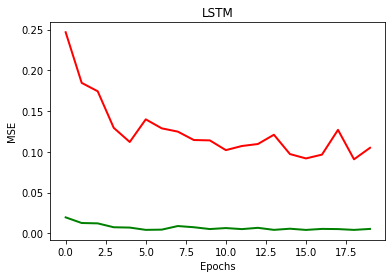

In [18]:
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

### Forecasting

4/4 [==============================] - 0s 3ms/step


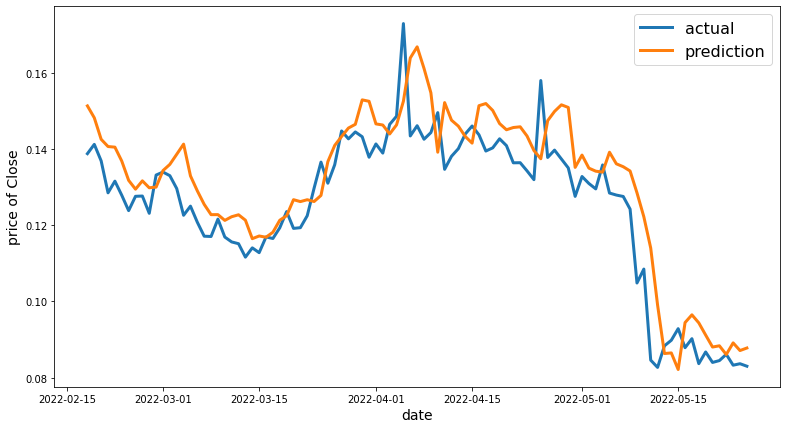

In [19]:
targets = test['close'][window_len:]

preds = model.predict(X_test).squeeze()
preds = test['close'].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

lines_plot([
    (targets, 'actual'),
    (preds, 'prediction')
], lw=3)


## Usage ML model

In [20]:
def predict_to_n(data, n):
    preds = []
    for _ in range(n):
        pr = model.predict(input_data)
        preds.append(pr[0][0])
        data = [[*data[0][1:], pr[0]]]
    return np.array(preds)

In [25]:
# Forecasing
# ==============================================================================
input_data = X_test[-2:-1].tolist()
preds = predict_to_n(input_data, n=3)
preds

1/1 [==============================] - 0s 20ms/step


array([0.00431639, 0.00431639, 0.00431639], dtype=float32)

In [26]:
# Scaling
# ==============================================================================
preds = test['close'].values[-window_len-3:-window_len] * (preds + 1)
preds

array([0.08401017, 0.08709687, 0.08433952])

In [27]:
# Create df
# ==============================================================================
last_day = test.index[-1]
date_list = [last_day + datetime.timedelta(days=x) for x in range(1, 4)]
preds = pd.Series(index=date_list, data=preds)
preds

2022-05-26    0.084010
2022-05-27    0.087097
2022-05-28    0.084340
dtype: float64

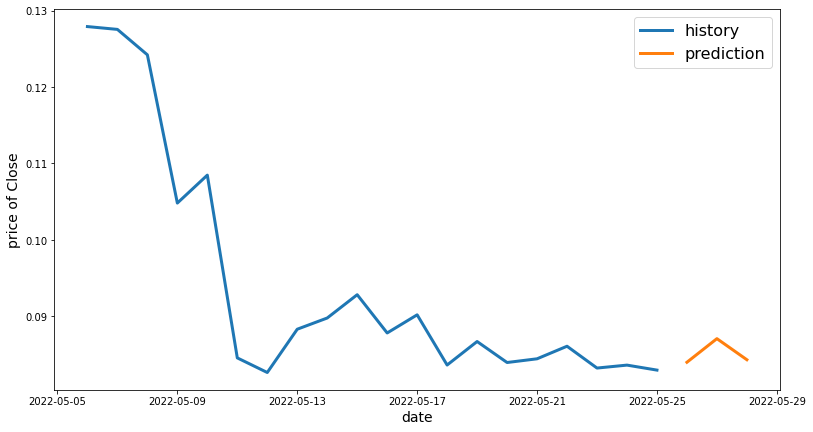

In [28]:
# Visualization
# ==============================================================================
lines_plot([
    (test['close'][-20:], 'history'),
    (preds, 'prediction')
], lw=3)